<a href="https://colab.research.google.com/github/Saoudyahya/Image-Debt-Estimation-Model/blob/main/Debt_Estimation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
==== Depth Estimation Demo ====
Model already exists at models/midas_v21_small_256.pt


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
<ipython-input-7-b71f38154bf8>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.m

MiDaS model loaded successfully!

Choose your option:
1. Process example image
2. Process image from URL
3. Upload your own image
4. Capture from webcam
Enter your choice (1-4): 3
Please upload an image:


Saving images.jpeg to images.jpeg
Processing images.jpeg...


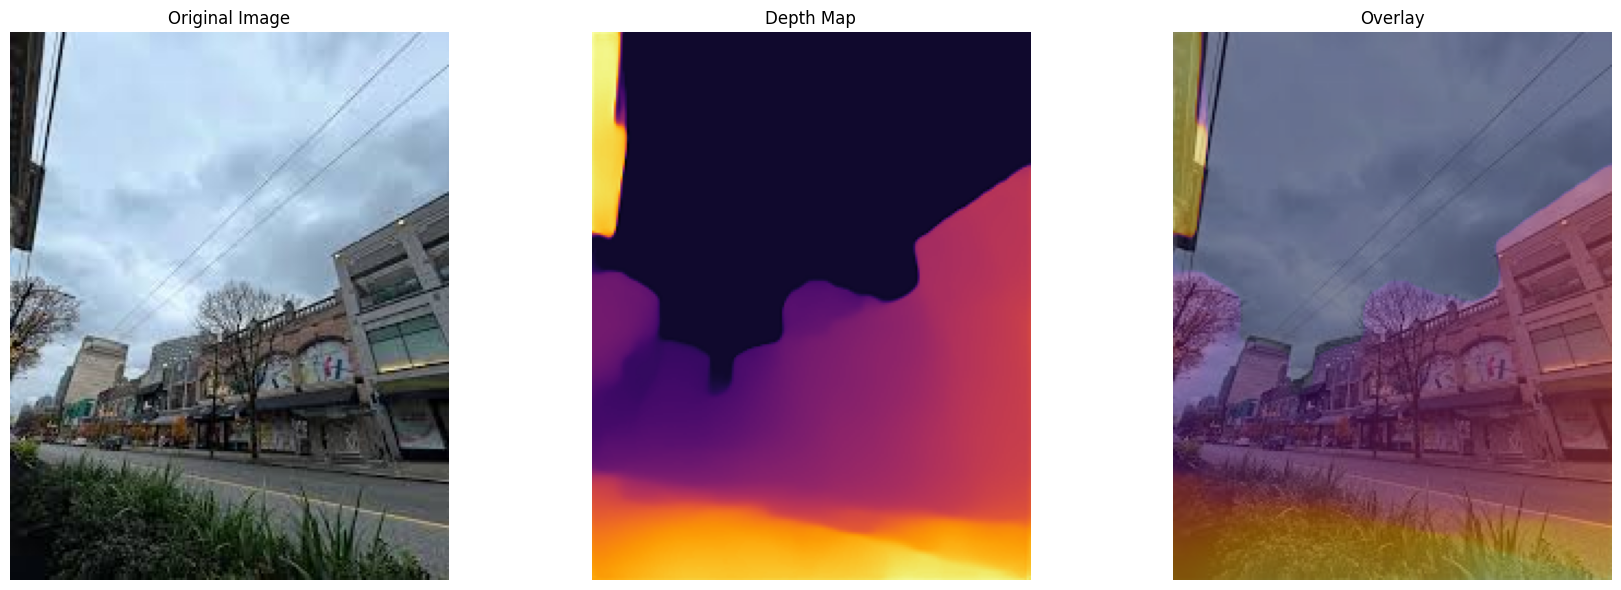


Would you like to see a 3D visualization? (yes/no)
yes


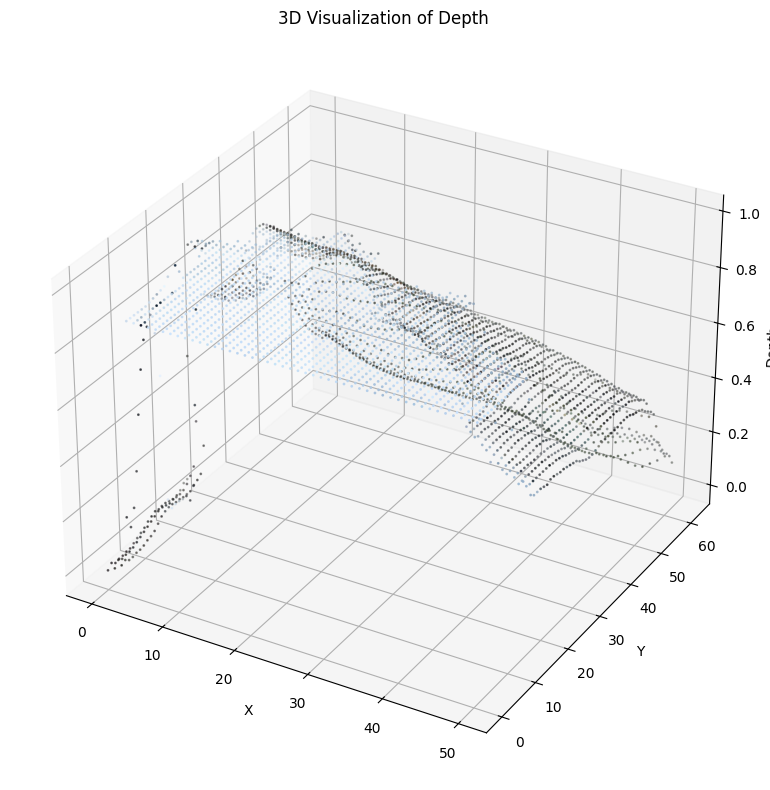


Would you like to save the results? (yes/no)
no

Depth estimation completed successfully!


In [7]:
# Depth Estimation from Images
# For Google Colab

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
import cv2
from PIL import Image
import urllib.request
from google.colab import files
from IPython.display import display, HTML

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Install required packages if not already installed
!pip install timm

# Download MiDaS model (if not already downloaded)
def download_model():
    print("Downloading MiDaS model weights...")
    os.makedirs("models", exist_ok=True)

    # Small model variant
    midas_model_url = "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt"
    model_path = "models/midas_v21_small_256.pt"

    if not os.path.exists(model_path):
        urllib.request.urlretrieve(midas_model_url, model_path)
        print(f"Model downloaded to {model_path}")
    else:
        print(f"Model already exists at {model_path}")

    return model_path

# Load MiDaS model
class MidasNet(torch.nn.Module):
    """MiDaS network architecture for depth estimation"""
    def __init__(self, path):
        super(MidasNet, self).__init__()
        self.model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
        if path:
            self.model.load_state_dict(torch.load(path, map_location=device))
        self.model.to(device)
        self.model.eval()

    def forward(self, x):
        with torch.no_grad():
            return self.model(x)

# Image preprocessing transformation
def transform_image(img):
    """Transform image for input to MiDaS"""
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    img = transform(img).unsqueeze(0).to(device)
    return img

# Estimate depth from image
def estimate_depth(img_path, model):
    """Estimate depth from an image file"""
    # Load image
    if isinstance(img_path, str):
        img = Image.open(img_path).convert("RGB")
    else:
        img = Image.fromarray(img_path).convert("RGB")

    # Original image dimensions for later resizing
    width, height = img.size

    # Transform image for model input
    transformed_img = transform_image(img)

    # Predict depth
    with torch.no_grad():
        prediction = model(transformed_img)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=(height, width),
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    # Convert to numpy and normalize
    depth_map = prediction.cpu().numpy()
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min()) * 255.0
    depth_map = depth_map.astype(np.uint8)

    return depth_map, np.array(img)

# Visualization function
def visualize_depth(rgb_img, depth_map, colormap=cv2.COLORMAP_INFERNO, alpha=0.5):
    """Visualize depth map"""
    # Apply colormap to depth
    depth_colored = cv2.applyColorMap(depth_map, colormap)
    depth_colored = cv2.cvtColor(depth_colored, cv2.COLOR_BGR2RGB)

    # Resize RGB image if sizes don't match
    if rgb_img.shape[:2] != depth_colored.shape[:2]:
        rgb_img = cv2.resize(rgb_img, (depth_colored.shape[1], depth_colored.shape[0]))

    # Create overlay
    overlay = cv2.addWeighted(rgb_img, 1-alpha, depth_colored, alpha, 0)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(rgb_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(depth_colored)
    axes[1].set_title("Depth Map")
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    return depth_colored, overlay

# Function to process image from URL
def process_from_url(url, model, colormap=cv2.COLORMAP_INFERNO):
    """Process image from URL"""
    # Download image
    print(f"Downloading image from {url}")
    urllib.request.urlretrieve(url, "temp_image.jpg")

    # Estimate depth
    depth_map, rgb_img = estimate_depth("temp_image.jpg", model)

    # Visualize
    depth_colored, overlay = visualize_depth(rgb_img, depth_map, colormap)

    # Clean up
    if os.path.exists("temp_image.jpg"):
        os.remove("temp_image.jpg")

    return rgb_img, depth_map, depth_colored, overlay

# Function to process uploaded image
def process_uploaded_image(model, colormap=cv2.COLORMAP_INFERNO):
    """Process uploaded image"""
    print("Please upload an image:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Processing {filename}...")
        depth_map, rgb_img = estimate_depth(filename, model)
        depth_colored, overlay = visualize_depth(rgb_img, depth_map, colormap)

    return rgb_img, depth_map, depth_colored, overlay

# Function to process image from webcam
def process_from_webcam(model, colormap=cv2.COLORMAP_INFERNO):
    """Capture and process image from webcam"""
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    js = Javascript('''
    async function takePhoto() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => {
        capture.onclick = resolve;
      });

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg');
    }
    ''')

    display(js)
    data = eval_js('takePhoto()')
    binary = b64decode(data.split(',')[1])

    # Convert binary to numpy array
    jpg_as_np = np.frombuffer(binary, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Estimate depth
    depth_map, _ = estimate_depth(img, model)

    # Visualize
    depth_colored, overlay = visualize_depth(img, depth_map, colormap)

    return img, depth_map, depth_colored, overlay

# Function to perform 3D visualization from depth map
def visualize_3d(rgb_img, depth_map, downsample=4):
    """Create 3D visualization from depth map"""
    try:
        from mpl_toolkits.mplot3d import Axes3D
    except:
        print("3D plotting requires mpl_toolkits.mplot3d")
        return

    # Downsample for performance
    h, w = depth_map.shape
    depth_downsampled = depth_map[::downsample, ::downsample]
    rgb_downsampled = rgb_img[::downsample, ::downsample]

    # Create meshgrid
    y, x = np.mgrid[0:depth_downsampled.shape[0], 0:depth_downsampled.shape[1]]

    # Create figure
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create surface plot
    z = depth_downsampled / 255.0  # Normalize to 0-1
    # Flip z to make closer objects higher
    z = 1 - z

    # Flatten for scatter
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()

    # Get colors from RGB image
    colors = rgb_downsampled.reshape(-1, 3) / 255.0

    # Plot
    ax.scatter(x_flat, y_flat, z_flat, c=colors, s=1)

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Depth')
    ax.set_title('3D Visualization of Depth')

    plt.tight_layout()
    plt.show()

# Save results function
def save_results(rgb_img, depth_map, depth_colored, overlay):
    """Save all results to files"""
    cv2.imwrite("original.jpg", cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite("depth_map.jpg", depth_map)
    cv2.imwrite("depth_colored.jpg", cv2.cvtColor(depth_colored, cv2.COLOR_RGB2BGR))
    cv2.imwrite("overlay.jpg", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    print("Results saved to:")
    print("  - original.jpg")
    print("  - depth_map.jpg")
    print("  - depth_colored.jpg")
    print("  - overlay.jpg")

    # Download files
    for file in ["original.jpg", "depth_map.jpg", "depth_colored.jpg", "overlay.jpg"]:
        files.download(file)

# Main function to run the demo
def run_depth_estimation_demo():
    """Run full depth estimation demo"""
    print("==== Depth Estimation Demo ====")

    # Download model
    model_path = download_model()

    # Setup MiDaS model
    try:
        model = MidasNet(model_path)
        print("MiDaS model loaded successfully!")
    except Exception as e:
        print(f"Error loading MiDaS model: {e}")
        print("Trying to load model directly from torch hub...")
        try:
            model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small").to(device)
            model.eval()
            print("Successfully loaded MiDaS model from torch hub!")
        except Exception as e:
            print(f"Failed to load model: {e}")
            return

    print("\nChoose your option:")
    print("1. Process example image")
    print("2. Process image from URL")
    print("3. Upload your own image")
    print("4. Capture from webcam")

    choice = input("Enter your choice (1-4): ")

    if choice == "1":
        # Process example image
        example_url = "https://github.com/intel-isl/MiDaS/raw/master/MiDaS/assets/samples/sample.png"
        rgb_img, depth_map, depth_colored, overlay = process_from_url(example_url, model)

    elif choice == "2":
        # Process from URL
        url = input("Enter image URL: ")
        rgb_img, depth_map, depth_colored, overlay = process_from_url(url, model)

    elif choice == "3":
        # Process uploaded image
        rgb_img, depth_map, depth_colored, overlay = process_uploaded_image(model)

    elif choice == "4":
        # Process from webcam
        rgb_img, depth_map, depth_colored, overlay = process_from_webcam(model)

    else:
        print("Invalid choice! Using example image.")
        example_url = "https://github.com/intel-isl/MiDaS/raw/master/MiDaS/assets/samples/sample.png"
        rgb_img, depth_map, depth_colored, overlay = process_from_url(example_url, model)

    # Additional visualizations
    print("\nWould you like to see a 3D visualization? (yes/no)")
    viz_3d = input().lower().startswith('y')

    if viz_3d:
        visualize_3d(rgb_img, depth_map)

    # Save results
    print("\nWould you like to save the results? (yes/no)")
    save = input().lower().startswith('y')

    if save:
        save_results(rgb_img, depth_map, depth_colored, overlay)

    print("\nDepth estimation completed successfully!")
    return rgb_img, depth_map, depth_colored, overlay

# Run the demo
if __name__ == "__main__":
    run_depth_estimation_demo()